### **Prediksi Harga Rumah di Kota Amsterdam Mennggunakan Alogritma KNN, RF dan Bost**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import  OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

Melakukan import Library yang dibutuhkan
Selanjutnya import dataset yang sudah di download

In [4]:
df = pd.read_csv('/content/HousingPrices-Amsterdam-August-2021.csv')
df.head(10)

,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538
5,6,"De Wittenkade 134 I, Amsterdam",1051 AM,450000.0,53,2,4.875024,52.382228
6,7,"Pruimenstraat 18 B, Amsterdam",1033 KM,450000.0,87,3,4.896536,52.410585
7,8,"Da Costakade 32 II, Amsterdam",1053 WL,590000.0,80,2,4.871555,52.371041
8,9,"Postjeskade 41 2, Amsterdam",1058 DG,399000.0,49,3,4.854671,52.363471
9,10,"Van Ostadestraat 193 H, Amsterdam",1073 TM,300000.0,33,2,4.897142,52.353111


### Exploratory Data Analysis



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  924 non-null    int64  
 1   Address     924 non-null    object 
 2   Zip         924 non-null    object 
 3   Price       920 non-null    float64
 4   Area        924 non-null    int64  
 5   Room        924 non-null    int64  
 6   Lon         924 non-null    float64
 7   Lat         924 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 57.9+ KB


In [6]:
df = df.dropna()

In [7]:
postal_code_district = pd.DataFrame(np.array([
    [1011, 1018, 1], [1019, 1019, 2], [1020, 1029, 3],
    [1030, 1039, 4], [1040, 1049, 5], [1050, 1059, 6], 
    [1060, 1069, 7], [1070, 1083, 8], [1086, 1099, 9], 
    [1100, 1108, 10], [1109, 1109, 11]]), 
    columns = ['under', 'upper', 'dstrct_id'])

postal_code_district

,under,upper,dstrct_id
0,1011,1018,1
1,1019,1019,2
2,1020,1029,3
3,1030,1039,4
4,1040,1049,5
5,1050,1059,6
6,1060,1069,7
7,1070,1083,8
8,1086,1099,9
9,1100,1108,10


In [8]:
df['temp'] = df['Zip'].apply( lambda x: int(float((x.split(' ', 1)[0]))))
df['district'] = df['temp'].apply( lambda x: postal_code_district.loc[(postal_code_district['under'] <= x) & (postal_code_district['upper'] >= x), 'dstrct_id'].values[0])

membuat kolum baru 'district' dengan menggabungkan kolum zip dan temp

In [9]:
df['Price'] = df['Price']//1000
df = df.drop(['Zip', 'Address', 'temp', 'Unnamed: 0'], axis=1)
df.head(10)

,Price,Area,Room,Lon,Lat,district
0,685.0,64,3,4.907736,52.356157,9
1,475.0,60,3,4.850476,52.348586,6
2,850.0,109,4,4.944774,52.343782,9
3,580.0,128,6,4.789928,52.343712,7
4,720.0,138,5,4.902503,52.410538,4
5,450.0,53,2,4.875024,52.382228,6
6,450.0,87,3,4.896536,52.410585,4
7,590.0,80,2,4.871555,52.371041,6
8,399.0,49,3,4.854671,52.363471,6
9,300.0,33,2,4.897142,52.353111,8


merubah harga rumah kedalam ratus ribu (Dolar) karena jikta tidak kita rubah akan sulid melihat hasil akhirnya nanti. lalu membuang kolum yang tidak diperlukan

In [10]:
df[['district', 'Room']] = df[['district', 'Room']].astype(str).astype(object)

mengganti tipe data menjadi object pada kolum (Room dan district)

In [11]:
df.describe()

,Price,Area,Lon,Lat
count,920.000000,920.000000,920.000000,920.000000
mean,622.057609,95.607609,4.888652,52.363271
std,538.995606,56.849699,0.053118,0.024054
min,175.000000,21.000000,4.644819,52.291519
25%,350.000000,60.000000,4.855834,52.351925
50%,467.000000,83.000000,4.886818,52.364499
75%,700.000000,113.000000,4.922337,52.377545
max,5950.000000,623.000000,5.029122,52.423805


### **Mencari Missing Value dan Outlier**

In [12]:
df.isnull().sum()

Price       0
Area        0
Room        0
Lon         0
Lat         0
district    0
dtype: int64

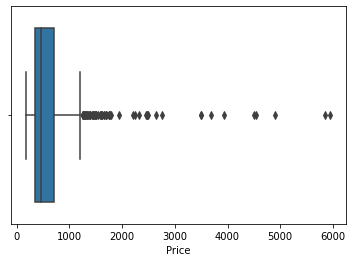

In [13]:
sns.boxplot(x=df['Price'])

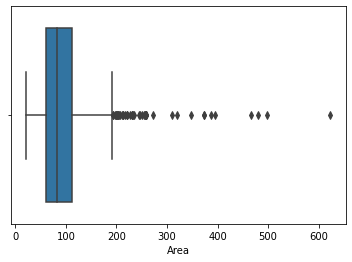

In [14]:
sns.boxplot(x=df['Area'])

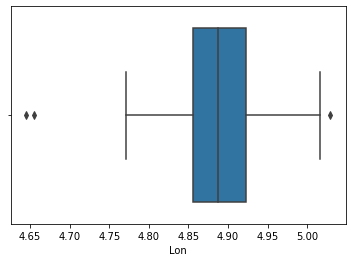

In [15]:
sns.boxplot(x=df['Lon'])

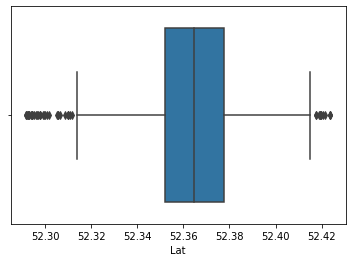

In [16]:
sns.boxplot(x=df['Lat'])

In [17]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR=Q3-Q1
df=df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]
 
df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  after removing the cwd from sys.path.


(792, 6)

### **Univariate Analysis**

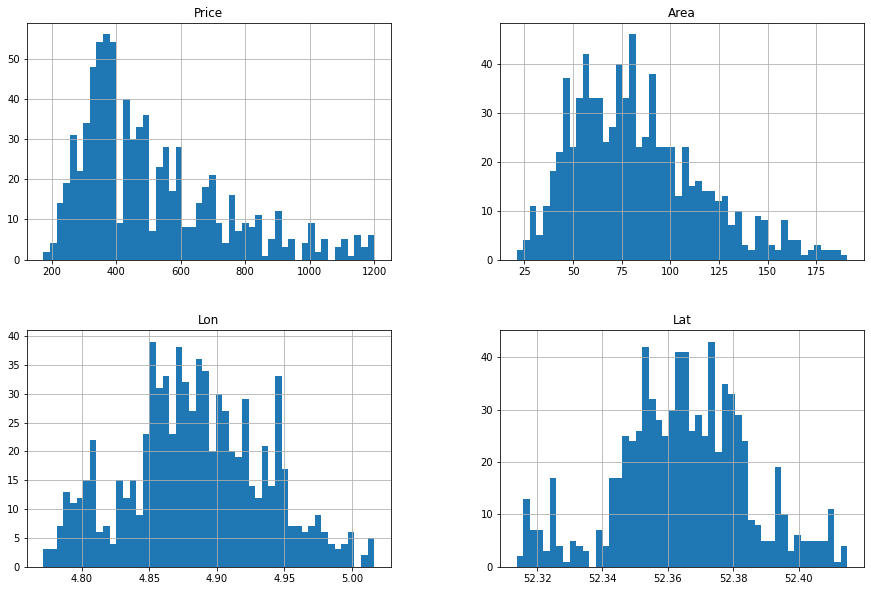

In [18]:
df.hist(bins=50, figsize=(15,10))
plt.show()

### **Categorical Features**

In [19]:
categorical_features = ['Room', 'district']

   Total Ruangan  persentase
3            313        39.5
2            183        23.1
4            173        21.8
5             67         8.5
6             29         3.7
1             16         2.0
7              8         1.0
8              2         0.3
9              1         0.1


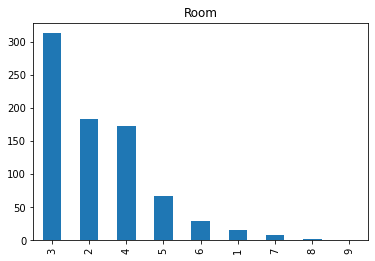

In [20]:
feature = categorical_features[0]
count = df[feature].value_counts()
percent = 100*df[feature].value_counts(normalize=True)
new_df = pd.DataFrame({'Total Ruangan': count,
                   'persentase': percent.round(1)})
print(new_df)
count.plot(kind='bar', title=feature)

    Total Ruangan  persentase
6             171        21.6
7             148        18.7
1             127        16.0
8             104        13.1
9              95        12.0
3              47         5.9
10             44         5.6
4              36         4.5
2              20         2.5


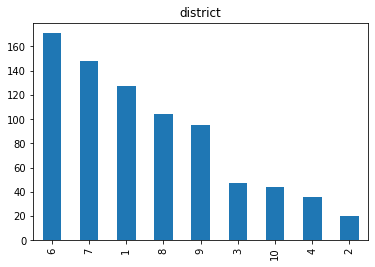

In [21]:
feature = categorical_features[1]
count = df[feature].value_counts()
percent = 100*df[feature].value_counts(normalize=True)
new_df = pd.DataFrame({'Total Ruangan': count,
                   'persentase': percent.round(1)})
print(new_df)
count.plot(kind='bar', title=feature)

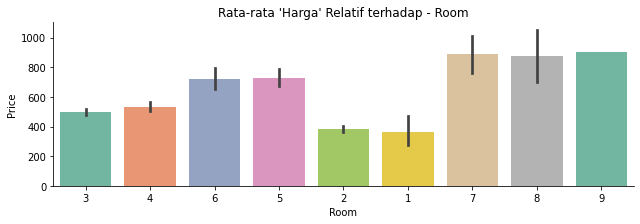

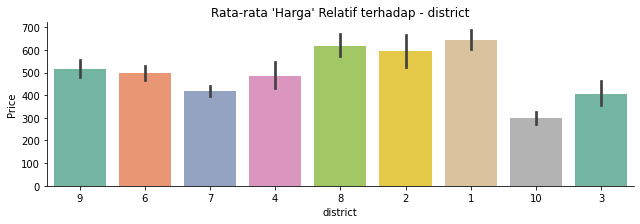

In [22]:
cat_features = df.select_dtypes(include='object').columns.to_list()
 
for col in cat_features:
  sns.catplot(x=col, y="Price", kind="bar", dodge=False, height = 3, aspect = 3,  data=df, palette="Set2")
  plt.title("Rata-rata 'Harga' Relatif terhadap - {}".format(col))


### **Multivariate Anlysis**

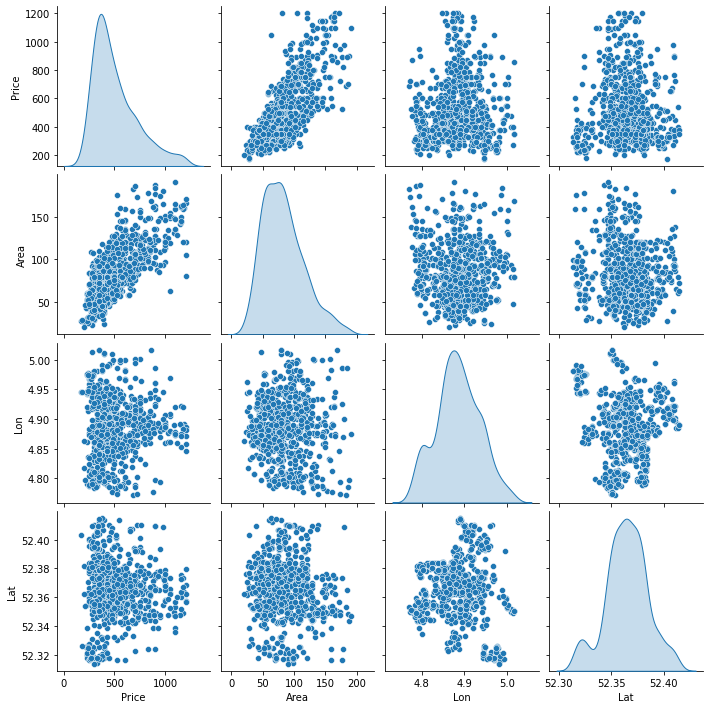

In [23]:
sns.pairplot(df, diag_kind = 'kde')


### **Corelation Matrix**

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

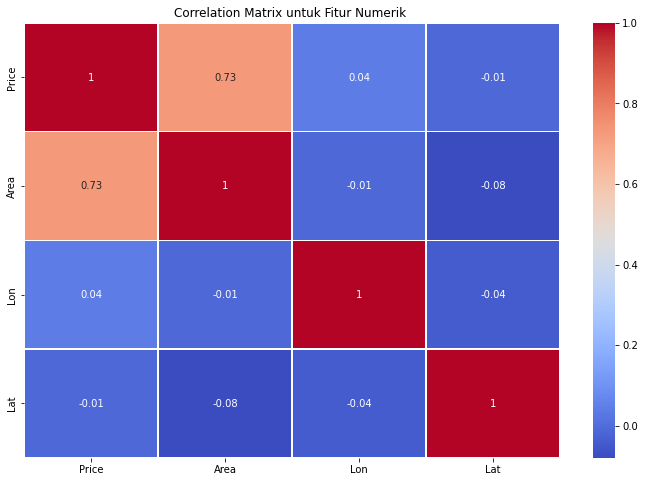

In [24]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr().round(2)
 

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=12)

### **Encoding**

In [25]:
df = pd.concat([df, pd.get_dummies(df['Room'], prefix='Room')],axis=1)
df = pd.concat([df, pd.get_dummies(df['district'], prefix='district')],axis=1)
df.drop(['Room', 'district'], axis=1, inplace=True)
df.head(10)

,Price,Area,Lon,Lat,Room_1,Room_2,Room_3,Room_4,Room_5,Room_6,...,Room_9,district_1,district_10,district_2,district_3,district_4,district_6,district_7,district_8,district_9
0,685.0,64,4.907736,52.356157,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,475.0,60,4.850476,52.348586,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,850.0,109,4.944774,52.343782,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,580.0,128,4.789928,52.343712,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,720.0,138,4.902503,52.410538,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
5,450.0,53,4.875024,52.382228,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,450.0,87,4.896536,52.410585,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,590.0,80,4.871555,52.371041,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,399.0,49,4.854671,52.363471,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,300.0,33,4.897142,52.353111,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


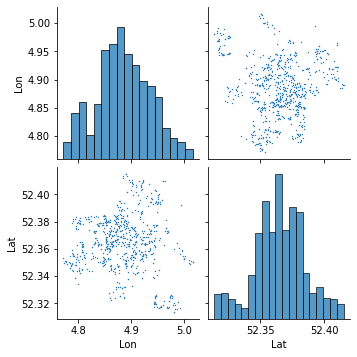

In [26]:
sns.pairplot(df[['Lon', 'Lat']], plot_kws={"s": 2});

### **Data Preparation**

In [27]:
X = df.drop(["Price"],axis =1)
y = df["Price"]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

train test split

### **Standarisasi**

In [29]:
numerical_features = ['Lon', 'Lat']
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train.loc[:, numerical_features])
X_train[numerical_features].head()

,Lon,Lat
455,-0.353364,0.521595
724,-0.542980,-0.215850
855,-1.530179,-0.391195
854,0.456605,0.309783
310,-1.053200,-0.543653


In [30]:
X_train[numerical_features].describe().round(2)

,Lon,Lat
count,633.00,633.00
mean,0.00,-0.00
std,1.00,1.00
min,-2.25,-2.59
25%,-0.62,-0.61
50%,-0.03,-0.01
75%,0.69,0.65
max,2.60,2.50


### **Model Development**

In [31]:
models = pd.DataFrame(index=['train_mse', 'test_mse'],
                      columns=['Boosting', 'RandomForest', 'knn'])

**Random Forest**

In [32]:
RF = RandomForestRegressor(n_estimators=150, max_depth=16, random_state=100)
RF.fit(X_train, y_train)
 
models.loc['train_mse','RandomForest'] = mean_squared_error(y_pred=RF.predict(X_train), y_true=y_train)

**Boosting Algortihm**

In [33]:
boosting = AdaBoostRegressor(random_state=100, learning_rate=0.001, n_estimators=50)
boosting.fit(X_train, y_train)
models.loc['train_mse','Boosting'] = mean_squared_error(y_pred=boosting.predict(X_train), y_true=y_train)


**KN Neighbors**

In [34]:
knn = KNeighborsRegressor(n_neighbors=13)
knn.fit(X_train, y_train)
 
models.loc['train_mse','knn'] = mean_squared_error(y_pred = knn.predict(X_train), y_true=y_train)


In [35]:
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])


### **Evaluasi Model**

In [36]:
mse = pd.DataFrame(columns=['train', 'test'], index=['RF','Boosting', 'KNN'])
 

model_dict = {'RF': RF, 'Boosting': boosting, 'KNN': knn}
 
for name, model in model_dict.items():
    mse.loc[name, 'train'] = mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))/1e4
    mse.loc[name, 'test'] = mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))/1e4

mse


,train,test
RF,0.112036,0.853549
Boosting,1.410523,1.847584
KNN,1.670121,2.24782


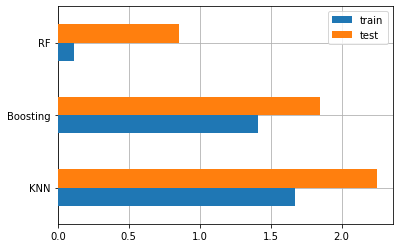

In [37]:
fig, ax = plt.subplots()
mse.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)


Nilai akurasi Model

In [38]:
knn_accuracy = knn.score(X_test, y_test)*100
rf_accuracy = RF.score(X_test, y_test)*100
boosting_accuracy = boosting.score(X_test, y_test)*100


In [39]:
list_evaluasi = [[knn_accuracy],
            [rf_accuracy],
            [boosting_accuracy]]
evaluasi = pd.DataFrame(list_evaluasi,
                        columns=['Accuracy (%)'],
                        index=['K-Nearest Neighbor', 'Random Forest', 'Boosting'])
evaluasi

,Accuracy (%)
K-Nearest Neighbor,50.408412
Random Forest,81.168932
Boosting,59.238446


In [40]:
prediksi = X_test.iloc[:20].copy()
pred_dict = {'y_true':y_test[:20]}
for name, model in model_dict.items():
    pred_dict['prediksi_'+name] = model.predict(prediksi).round(1)
 
pd.DataFrame(pred_dict)


,y_true,prediksi_RF,prediksi_Boosting,prediksi_KNN
736,335.0,415.0,485.2,512.2
162,1050.0,871.5,868.3,872.1
820,500.0,539.4,466.2,533.0
63,850.0,872.1,899.4,681.5
595,520.0,482.6,448.7,489.5
840,575.0,695.7,678.1,753.1
14,650.0,611.6,468.1,533.8
46,475.0,483.7,461.9,514.3
91,395.0,372.8,371.7,401.8
317,995.0,898.6,921.0,920.2


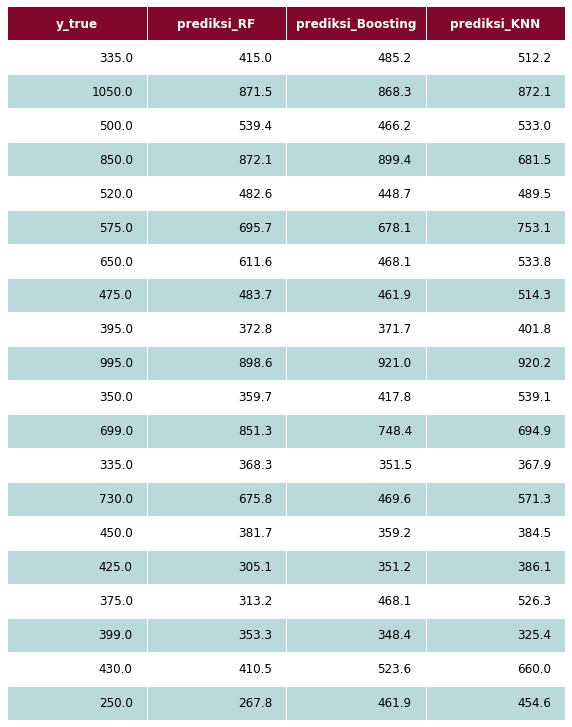

In [41]:
def render_predict_table(data, col_width=7.0, row_height=0.625, font_size=12,
                     header_color='#82072c', row_colors=['#bad9db', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    predict_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    predict_table.auto_set_font_size(False)
    predict_table.set_fontsize(font_size)

    for k, cell in predict_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_predict_table(pd.DataFrame(pred_dict), header_columns=0, col_width=2.5)
fig.savefig("table_predict.png")
